In [1]:
import tensorflow as tf
from tensorflow import keras  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load data

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

In [4]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [6]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Balance data

In [7]:
non_fraud = data[data['Class']==0]
fraud = data[data['Class']==1]

In [8]:
non_fraud.shape,fraud.shape

((284315, 31), (492, 31))

In [9]:
non_fraud = non_fraud.sample(fraud.shape[0]) #get 492 samples from non_fraud

In [10]:
data = fraud.append(non_fraud, ignore_index=True)

In [11]:
data['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

## Prepare data for CNN

In [12]:
X=data.drop('Class',axis=1)
y=data['Class']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [14]:
X_train.shape,X_test.shape

((787, 30), (197, 30))

In [15]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train) 
X_test=scaler.transform(X_test)  #transform X-test depending on X-train
#每一个transform都需要先fit,
#比如把数据转为（0，1）分布，需要均值和标准差，
#fit_transform和transform的区别就是前者是先计算均值和标准差再转换，
#而直接transform则是用之前数据计算的参数转换。所以如果之前没有fit，是不能直接transform的

In [16]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1) #3D data for CNN
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1) #3D data for CNN
X_train.shape,X_test.shape

((787, 30, 1), (197, 30, 1))

In [17]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Build CNN

In [18]:
epochs=40

model=Sequential()

model.add(Conv1D(filters=32,kernel_size=2,activation='relu',input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(filters=64,kernel_size=2,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 32)            96        
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 29, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0

In [20]:
model.compile(optimizer=Adam(lr=0.00005),loss='binary_crossentropy',metrics=['accuracy'])
#lr: float >= 0. 学习率。

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
history=model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),verbose=1)

Train on 787 samples, validate on 197 samples
Epoch 1/40
787/787 [==============================] - 2s 2ms/sample - loss: 0.8289 - acc: 0.5934 - val_loss: 0.6554 - val_acc: 0.7919
Epoch 2/40
787/787 [==============================] - 0s 146us/sample - loss: 0.5005 - acc: 0.7891 - val_loss: 0.6130 - val_acc: 0.8579
Epoch 3/40
787/787 [==============================] - 0s 142us/sample - loss: 0.4915 - acc: 0.7751 - val_loss: 0.5720 - val_acc: 0.8731
Epoch 4/40
787/787 [==============================] - 0s 151us/sample - loss: 0.3957 - acc: 0.8297 - val_loss: 0.5286 - val_acc: 0.8731
Epoch 5/40
787/787 [==============================] - 0s 147us/sample - loss: 0.3804 - acc: 0.8399 - val_loss: 0.4888 - val_acc: 0.8832
Epoch 6/40
787/787 [==============================] - 0s 150us/sample - loss: 0.3816 - acc: 0.8590 - val_loss: 0.4508 - val_acc: 0.8832
Epoch 7/40
787/787 [==============================] - 0s 149us/sample - loss: 0.3361 - acc: 0.8679 - val_loss: 0.4144 - val_acc: 0.8934
Epoc

## Evaluate model

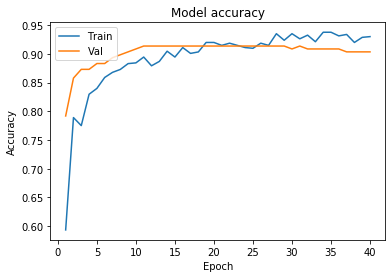

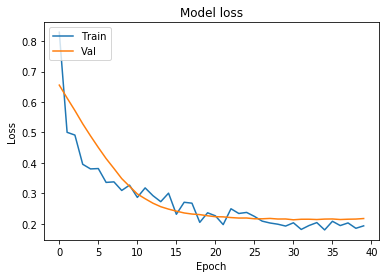

In [22]:
epoch_range=range(1,epochs+1)
plt.plot(epoch_range,history.history['acc'])
plt.plot(epoch_range,history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

#12-15 epochs is enough,, acc->0.9137

## Use the same model but with maxpooling layer

In [23]:
epochs=100

model=Sequential()

model.add(Conv1D(filters=32,kernel_size=2,activation='relu',input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64,kernel_size=2,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.00005),loss='binary_crossentropy',metrics=['accuracy'])

history=model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),verbose=1)




Train on 787 samples, validate on 197 samples
Epoch 1/100
787/787 [==============================] - 1s 639us/sample - loss: 1.3609 - acc: 0.5591 - val_loss: 0.6769 - val_acc: 0.7056
Epoch 2/100
787/787 [==============================] - 0s 181us/sample - loss: 1.1964 - acc: 0.5743 - val_loss: 0.6642 - val_acc: 0.6599
Epoch 3/100
787/787 [==============================] - 0s 174us/sample - loss: 0.9824 - acc: 0.6455 - val_loss: 0.6516 - val_acc: 0.6345
Epoch 4/100
787/787 [==============================] - 0s 161us/sample - loss: 0.8937 - acc: 0.6645 - val_loss: 0.6404 - val_acc: 0.6345
Epoch 5/100
787/787 [==============================] - 0s 156us/sample - loss: 0.8752 - acc: 0.6633 - val_loss: 0.6289 - val_acc: 0.6345
Epoch 6/100
787/787 [==============================] - 0s 152us/sample - loss: 0.7698 - acc: 0.6887 - val_loss: 0.6150 - val_acc: 0.6396
Epoch 7/100
787/787 [==============================] - 0s 163us/sample - loss: 0.7168 - acc: 0.7179 - val_loss: 0.5983 - val_acc: 0.

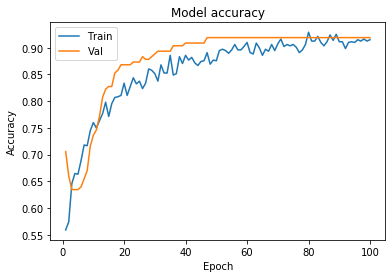

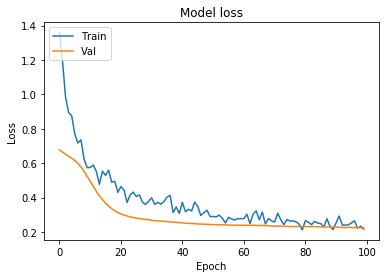

In [24]:
epoch_range=range(1,epochs+1)
plt.plot(epoch_range,history.history['acc'])
plt.plot(epoch_range,history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

# accuracy -> 0.9188 ,  48 epochs is enough